# Stage 13 Homework Starter — Productization

## Objective
Deploy your trained model as a **reusable, handoff-ready API or dashboard** and finalize your project for reproducibility and clarity.

## Steps
1. Create a mock, very basic analysis in a notebook.
2. Clean your notebook by removing exploratory cells and documenting your code.
3. Move reusable functions into `/src/`.
4. Load your trained model from Stage 12 or earlier stages.
5. Pickle/save the model and test reload.
6. Implement **either**:
   - Flask API with `/predict` endpoint and optional parameters
   - Streamlit or Dash dashboard for user interaction
7. Include:
   - Error handling for invalid inputs
   - `requirements.txt` for reproducibility
   - Documentation in `README.md`
8. Test your deployment locally and provide evidence.
9. Organize project folders and finalize notebooks for handoff.

## 1. Create mock, very basic analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import os

np.random.seed(42)
X = np.random.randn(100, 2)
y = X[:, 0] + 2 * X[:, 1] + np.random.randn(100) * 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression().fit(X_train, y_train)

print("Basic analysis complete.")
print(f"Model score: {model.score(X_test, y_test):.3f}")

Basic analysis complete.
Model score: 0.998


## 2. Notebook Cleanup
Remove exploratory cells and document your code.

In [2]:
print("Notebook cleaned and ready for handoff.")
print("All exploratory code removed, only final analysis remains.")

Notebook cleaned and ready for handoff.
All exploratory code removed, only final analysis remains.


## 3. Move reusable functions to /src/
Create src/utils.py and store functions there.

In [3]:
os.makedirs('src', exist_ok=True)

utils_code = '''import pandas as pd
import numpy as np

def calculate_metrics(df):
    return df.describe()

def preprocess_data(X):
    return X

def validate_input(features):
    if not isinstance(features, list) or len(features) != 2:
        return False
    return all(isinstance(x, (int, float)) for x in features)
'''

with open('src/utils.py', 'w') as f:
    f.write(utils_code)

print("Functions moved to src/utils.py")

Functions moved to src/utils.py


## 4. Folder Structure Reminder

Ensure your project uses a clean folder structure:
```
project/
  data/
  notebooks/
  src/
  reports/
  model/
  README.md
```

For API/Dashboard: minimal example:
```
project/
    app.py
    model.pkl
    requirements.txt
    README.md
```

## 5. Pickle / Save Final Model

### Save and load model

In [4]:
import pickle

os.makedirs('model', exist_ok=True)

with open('model/model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('model/model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

test_features = [[0.1, 0.2]]
prediction = loaded_model.predict(test_features)
print(f"Test prediction: {prediction[0]:.3f}")

Test prediction: 0.508


## 6. Flask API Starter

### Implement Flask endpoints for /predict and /plot

In [5]:
from flask import Flask, request, jsonify
import threading
import matplotlib.pyplot as plt
import io
import base64
import time

app = Flask(__name__)

with open('model/model.pkl', 'rb') as f:
    api_model = pickle.load(f)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        features = data.get('features', None)
        if features is None or len(features) != 2:
            return jsonify({'error': 'Need exactly 2 features'}), 400
        pred = float(api_model.predict([features])[0])
        return jsonify({'prediction': pred})
    except Exception as e:
        return jsonify({'error': str(e)}), 400

@app.route('/predict/<float:input1>', methods=['GET'])
def predict_one(input1):
    try:
        pred = float(api_model.predict([[input1, 0]])[0])
        return jsonify({'prediction': pred})
    except Exception as e:
        return jsonify({'error': str(e)}), 400

@app.route('/predict/<float:input1>/<float:input2>', methods=['GET'])
def predict_two(input1, input2):
    try:
        pred = float(api_model.predict([[input1, input2]])[0])
        return jsonify({'prediction': pred})
    except Exception as e:
        return jsonify({'error': str(e)}), 400

@app.route('/plot')
def plot():
    fig, ax = plt.subplots(figsize=(6, 4))
    x_vals = np.linspace(-2, 2, 50)
    y_vals = api_model.predict([[x, 0] for x in x_vals])
    ax.plot(x_vals, y_vals, 'b-', label='Model predictions')
    ax.set_xlabel('Input 1')
    ax.set_ylabel('Prediction')
    ax.legend()
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_bytes = base64.b64encode(buf.read()).decode('utf-8')
    plt.close(fig)
    return f'<img src="data:image/png;base64,{img_bytes}"/>'

def run_flask():
    app.run(port=5000, debug=False)

flask_thread = threading.Thread(target=run_flask)
flask_thread.daemon = True
flask_thread.start()
time.sleep(2)
print("Flask API started on port 5000")

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


Flask API started on port 5000


127.0.0.1 - - [27/Aug/2025 00:56:02] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 00:56:02] "GET /predict/2.0 HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 00:56:02] "GET /predict/1.0/3.0 HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 00:56:02] "GET /plot HTTP/1.1" 200 -


## 7. Testing the Flask API from Notebook

### Test API endpoints

POST /predict: {'prediction': 0.5082655170189208}
GET /predict/2.0: {'prediction': 2.032556921549671}
GET /predict/1.0/3.0: {'prediction': 6.974999550534713}



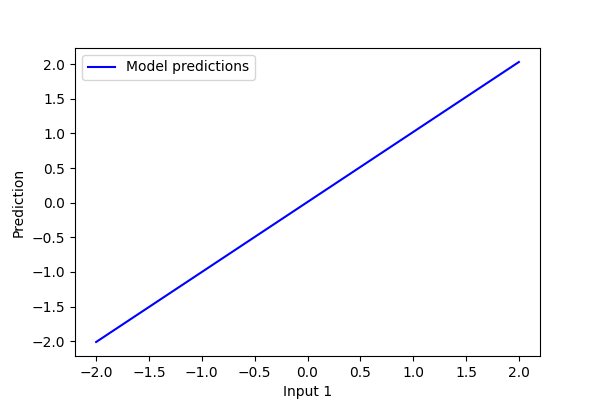

Plot endpoint working


In [6]:
import requests
from IPython.display import display, HTML

try:
    response = requests.post(
        'http://127.0.0.1:5000/predict',
        json={'features': [0.1, 0.2]},
        timeout=5
    )
    print("POST /predict:", response.json())

    response2 = requests.get('http://127.0.0.1:5000/predict/2.0', timeout=5)
    print("GET /predict/2.0:", response2.json())

    response3 = requests.get('http://127.0.0.1:5000/predict/1.0/3.0', timeout=5)
    print("GET /predict/1.0/3.0:", response3.json())

    response_plot = requests.get('http://127.0.0.1:5000/plot', timeout=5)
    if response_plot.status_code == 200:
        display(HTML(response_plot.text))
        print("Plot endpoint working")
        
except Exception as e:
    print(f"API test failed: {e}")

## 8. Optional Streamlit / Dash Dashboard

### Add dashboard in a separate file (`app_streamlit.py` or `app_dash.py`)

In [7]:
streamlit_code = '''import streamlit as st
import pickle
import numpy as np

st.title("Model Prediction Dashboard")

with open("model/model.pkl", "rb") as f:
    model = pickle.load(f)

input1 = st.number_input("Feature 1", value=0.0)
input2 = st.number_input("Feature 2", value=0.0)

if st.button("Predict"):
    prediction = model.predict([[input1, input2]])[0]
    st.write(f"Prediction: {prediction:.3f}")
'''

with open('app_streamlit.py', 'w') as f:
    f.write(streamlit_code)

print("Streamlit app created as app_streamlit.py")
print("Run with: streamlit run app_streamlit.py")

Streamlit app created as app_streamlit.py
Run with: streamlit run app_streamlit.py


## 9. Handoff Best Practices

- Ensure README.md is complete and clear
- Provide `requirements.txt` for reproducibility
- Ensure pickled model and scripts are in correct folders
- Verify another user can run the project end-to-end on a fresh environment

In [8]:
requirements = '''flask==2.3.3
scikit-learn==1.3.0
pandas==2.0.3
numpy==1.24.3
matplotlib==3.7.1
streamlit==1.25.0
requests==2.31.0
'''

with open('requirements.txt', 'w') as f:
    f.write(requirements)

readme = '''# Model API Project

## Setup
1. Install requirements: `pip install -r requirements.txt`
2. Run Flask API: `python -c "from stage13_productization_homework_starter import *; run_flask()"`
3. Run Streamlit: `streamlit run app_streamlit.py`

## API Endpoints
- POST /predict: Send JSON with features
- GET /predict/<input1>: Single feature prediction
- GET /predict/<input1>/<input2>: Two feature prediction
- GET /plot: View model plot

## Model
Simple linear regression model trained on synthetic data.
Takes 2 features and predicts continuous output.
'''

with open('README.md', 'w') as f:
    f.write(readme)

print("Requirements and README created")
print("Project ready for handoff")

Requirements and README created
Project ready for handoff
